In [8]:
import torch
from dataloaders.brats2021 import BRATS2021EncoderSegDataset
from glob import glob
from gridencoder import GridEncoder
import os
import nibabel as nib

import torch
from torch import nn
%pylab
%matplotlib notebook

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [9]:
encoder = GridEncoder(level_dim=4, desired_resolution=196, gridtype='tiled', align_corners=True).cuda()
decoder = nn.Sequential(
    nn.Linear(64, 256),
    nn.LeakyReLU(),
    nn.Linear(256, 4)
).cuda()
decoder.load_state_dict(torch.load('/data/Implicit3DCNNTasks/brats2021/decoder.pth'))

<All keys matched successfully>

In [22]:
encoders = sorted(glob("/data/Implicit3DCNNTasks/brats2021/encoder_BraTS2021_*pth"))

In [17]:
idx = int(input("Enter index: "))
enc = encoders[idx]
data = torch.load(enc)
# data['embeddings'] = data['embeddings']*2.0 + 0.5 * torch.randn_like(data['embeddings']) * data['embeddings'].std(0)[None]
encoder.load_state_dict(data)

# run eval
HWD = torch.tensor([240, 240, 155]).long()
xyz = torch.meshgrid([torch.arange(t) for t in HWD], indexing='ij')
xyz = torch.stack(xyz, dim=-1).reshape(-1, 3)
xyz = xyz / (HWD - 1) * 2 - 1

with torch.no_grad():
    imgs = []
    sz = xyz.shape[0]//64
    for i in range(64):
        minixyz = xyz[sz*i:sz*(i+1)].cuda()
        img = decoder(encoder(minixyz))
        imgs.append(img.cpu())
        
imgs = torch.stack(imgs, dim=0).reshape(240, 240, 155, 4)

Enter index: 3


<IPython.core.display.Javascript object>


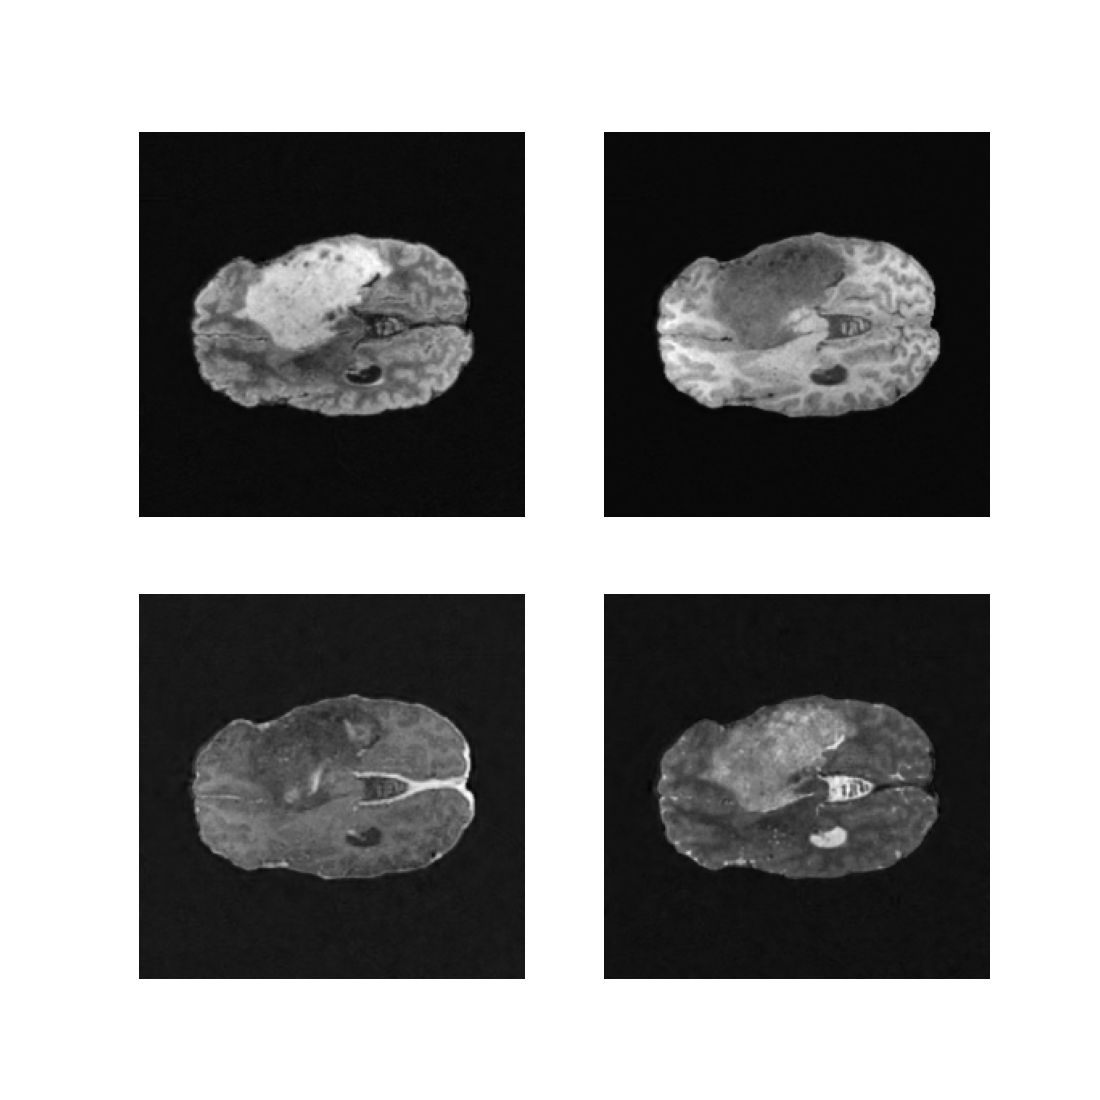

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i in range(2):
    for j in range(2):
        axs[i][j].imshow(imgs[:, :, 60, i*2 + j].data.cpu().numpy(), cmap='gray')
        axs[i][j].axis('off')

<IPython.core.display.Javascript object>


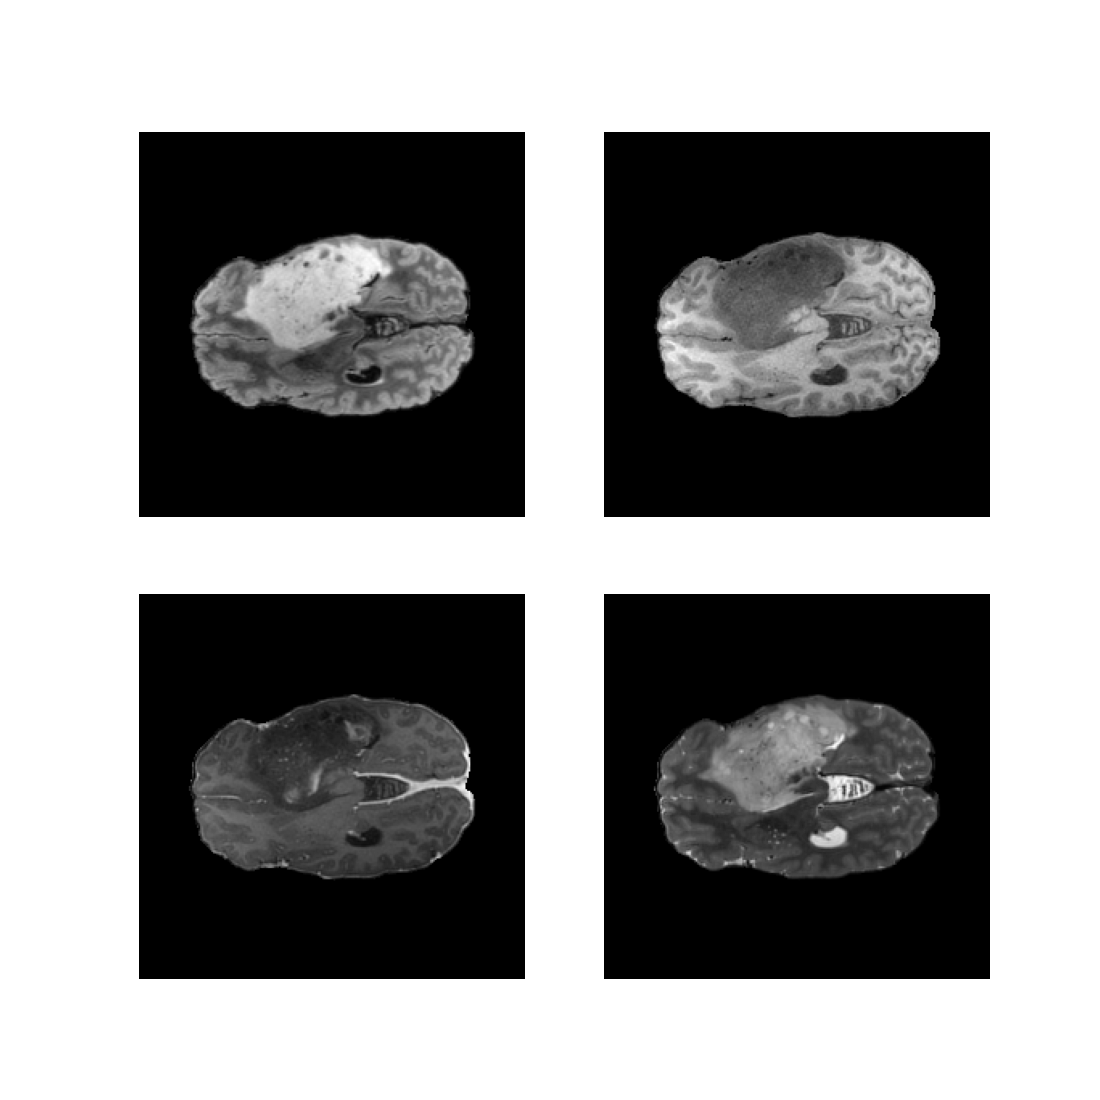

In [20]:
# # brats_path = sorted(glob("/data/BRATS2021/training/BraTS2021_00612/*nii.gz"))
# # del brats_path[1]
# # gtimgs = [nib.load(x).get_fdata() for x in brats_path]

# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# for i in range(2):
#     for j in range(2):
#         axs[i][j].imshow(gtimgs[i*2 + j][:, :, 60], cmap='gray')
#         axs[i][j].axis('off')

In [18]:
## Visualize brats images

In [21]:
brats_images = sorted(glob("/data/BRATS2021/training/*/"))

In [32]:
idx = int(input("Enter index (0-{}): ".format(len(brats_images))))
imgs = glob(os.path.join(brats_images[idx], '*nii.gz'))
imgs = list(filter(lambda x: 'seg' not in x, imgs))
print(imgs)
imgs = [nib.load(x).get_fdata() for x in imgs]

Enter index (0-1251): 11
['/data/BRATS2021/training/BraTS2021_00390/BraTS2021_00390_t2.nii.gz', '/data/BRATS2021/training/BraTS2021_00390/BraTS2021_00390_t1ce.nii.gz', '/data/BRATS2021/training/BraTS2021_00390/BraTS2021_00390_flair.nii.gz', '/data/BRATS2021/training/BraTS2021_00390/BraTS2021_00390_t1.nii.gz']


In [12]:
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# for i in range(2):
#     for j in range(2):
#         idx = i*2 + j
#         axs[i][j].hist(imgs[idx].reshape(-1), bins=500)
#         axs[i][j].set_yscale('log')

In [13]:
## Calculate PSNR

In [17]:
from utils.util import uniform_normalize

In [ ]:
for idx in range(len(encoders)):
    enc = encoders[idx]
    data = torch.load(enc)
    encoder.load_state_dict(data)
    print("Loaded state dict... {}".format(enc))
    
    # Get images
    print("Loading ground truth images... {}".format(brats_images[idx]))
    gtimgs = sorted(glob(os.path.join(brats_images[idx], '*nii.gz')))
    gtimgs = list(filter(lambda x: 'seg' not in x, gtimgs))
    print(gtimgs)
    gtimgs = [uniform_normalize(nib.load(x).get_fdata()) for x in gtimgs]
    print("Loaded ground truth images... {}".format(brats_images[idx]))
    
    # run eval
    HWD = torch.tensor([240, 240, 155]).long()
    xyz = torch.meshgrid([torch.arange(t) for t in HWD], indexing='ij')
    xyz = torch.stack(xyz, dim=-1).reshape(-1, 3)
    xyz = xyz / (HWD - 1) * 2 - 1

    with torch.no_grad():
        imgs = []
        sz = xyz.shape[0]//64
        for i in range(64):
            minixyz = xyz[sz*i:sz*(i+1)].cuda()
            img = decoder(encoder(minixyz))
            imgs.append(img.cpu())

    predimgs = torch.stack(imgs, dim=0).reshape(240, 240, 155, 4)
    psnrs = []
    for i in range(4):
        p = (predimgs[..., i] - gtimgs[i])**2
        p = p.mean().item()
        psnrs.append(10*np.log10(4/p))
    print(idx, ", ".join([str(x) for x in psnrs]))

Loaded state dict... /data/Implicit3DCNNTasks/brats2021/encoder_BraTS2021_00000.pth
Loading ground truth images... /data/BRATS2021/training/BraTS2021_00000/
['/data/BRATS2021/training/BraTS2021_00000/BraTS2021_00000_flair.nii.gz', '/data/BRATS2021/training/BraTS2021_00000/BraTS2021_00000_t1.nii.gz', '/data/BRATS2021/training/BraTS2021_00000/BraTS2021_00000_t1ce.nii.gz', '/data/BRATS2021/training/BraTS2021_00000/BraTS2021_00000_t2.nii.gz']
Loaded ground truth images... /data/BRATS2021/training/BraTS2021_00000/
0 36.447154352545304, 38.16137885341628, 38.51027854411643, 36.534772579193685
Loaded state dict... /data/Implicit3DCNNTasks/brats2021/encoder_BraTS2021_00002.pth
Loading ground truth images... /data/BRATS2021/training/BraTS2021_00002/
['/data/BRATS2021/training/BraTS2021_00002/BraTS2021_00002_flair.nii.gz', '/data/BRATS2021/training/BraTS2021_00002/BraTS2021_00002_t1.nii.gz', '/data/BRATS2021/training/BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz', '/data/BRATS2021/training/BraTS20

In [16]:
encoders[44], brats_images[44]

('/data/Implicit3DCNNTasks/brats2021/encoder_BraTS2021_00656.pth',
 '/data/BRATS2021/training/BraTS2021_00028/')